In [1]:

import pandas as pd 
import pandasql as ps
import numpy as np
import math as mh
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from matplotlib.pyplot import figure
from scipy import stats
import matplotlib.pylab as plt
from IPython.core.pylabtools import figsize

figsize(20, 10)


In [2]:
figsize(20, 10)


# Collecting Data. 
## Hotjar

We should give the proper date format before reading .csv 

We only need 2 inputs. Date and Score. 

## Date: it shoud be the type of 'yyyy-mm-dd'.

## Score: 1 if the answer is positive, 0 else

In [3]:
df = pd.read_csv('CSAT_PRO_NewMethods.csv', sep = ';')
print(df.head())


q1 = """SELECT date(date) as dates,score FROM df"""

#print(ps.sqldf(q1, locals()))
df_n = ps.sqldf(q1, locals())
df_n.head()


         date           label  score
0  2019-10-09     Indeferente      0
1  2019-10-09  Muy Satisfecho      1
2  2019-10-09      Satisfecho      1
3  2019-10-09      Satisfecho      1
4  2019-10-09      Satisfecho      1


,dates,score
0,2019-10-09,0
1,2019-10-09,1
2,2019-10-09,1
3,2019-10-09,1
4,2019-10-09,1


In [4]:
df_n.dtypes


dates    object
score     int64
dtype: object

In [5]:
df = pd.read_csv('CSAT_PRO_NewMethods.csv', sep = ';')
print(df.head())


q1 = """SELECT date(Date) as dates,score FROM df"""

#print(ps.sqldf(q1, locals()))
df_n = ps.sqldf(q1, locals())
df_n.head()

df_n['dayofyear'] = pd.to_datetime(df_n['dates']).dt.dayofyear.astype(int)
df_n['dayofweek'] = pd.to_datetime(df_n['dates']).dt.dayofweek.astype(int)
df_n['week_'] = pd.to_datetime(df_n['dates']).dt.week.astype(int)
df_n['year_'] = pd.to_datetime(df_n['dates']).dt.year.astype(int)
df_n['month_'] = pd.to_datetime(df_n['dates']).dt.month.astype(int)
df_n.head()


         date           label  score
0  2019-10-09     Indeferente      0
1  2019-10-09  Muy Satisfecho      1
2  2019-10-09      Satisfecho      1
3  2019-10-09      Satisfecho      1
4  2019-10-09      Satisfecho      1


,dates,score,dayofyear,dayofweek,week_,year_,month_
0,2019-10-09,0,282,2,41,2019,10
1,2019-10-09,1,282,2,41,2019,10
2,2019-10-09,1,282,2,41,2019,10
3,2019-10-09,1,282,2,41,2019,10
4,2019-10-09,1,282,2,41,2019,10


## Daily

We have a huge volatility. That's why the daily non coocked time series is useless


          dates  month_  week_  year_ dayofyear  promoters  total_users  \
206  2019-10-31      10     44   2019   2019304          1            2   
207  2019-11-01      11     44   2019   2019305          1            1   
208  2019-11-02      11     44   2019   2019306          1            2   
209  2019-11-03      11     44   2019   2019307          1            1   
210  2019-11-04      11     45   2019   2019308          1            3   

           csat  
206   50.000000  
207  100.000000  
208   50.000000  
209  100.000000  
210   33.333333  


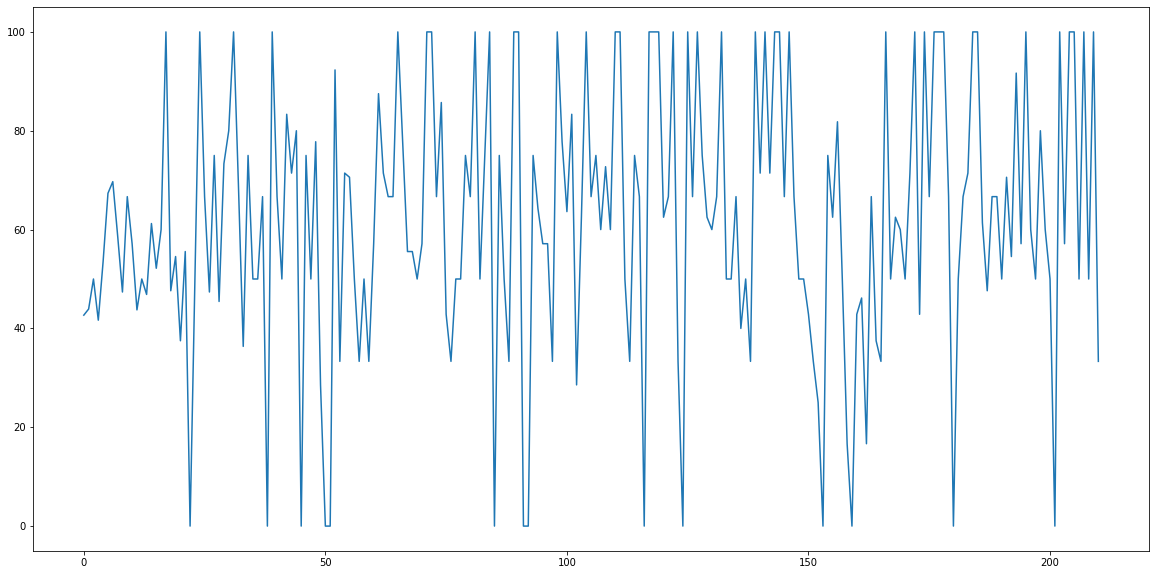

In [6]:

q2 = """SELECT * , 100.0*promoters/total_users as csat
        FROM (
        SELECT dates,month_,week_, year_ , year_||dayofyear as dayofyear,
        SUM(score) as promoters,
        COUNT(score) as total_users
        FROM df_n GROUP BY 1,2,3,4,5 ) a"""

#print(ps.sqldf(q1, locals()))
df_day = ps.sqldf(q2, locals())
print(df_day.tail())
plt.plot(df_day.csat)

## Weekly

We are more confident with the predictibility of the time series in week aggregates, but we are only able to report the value next week.

    month_  week_  year_  promoters  total_users       csat
34      10     42   2019         35           49  71.428571
35      10     43   2019         18           30  60.000000
36      10     44   2019          8           12  66.666667
37      11     44   2019          3            4  75.000000
38      11     45   2019          1            3  33.333333


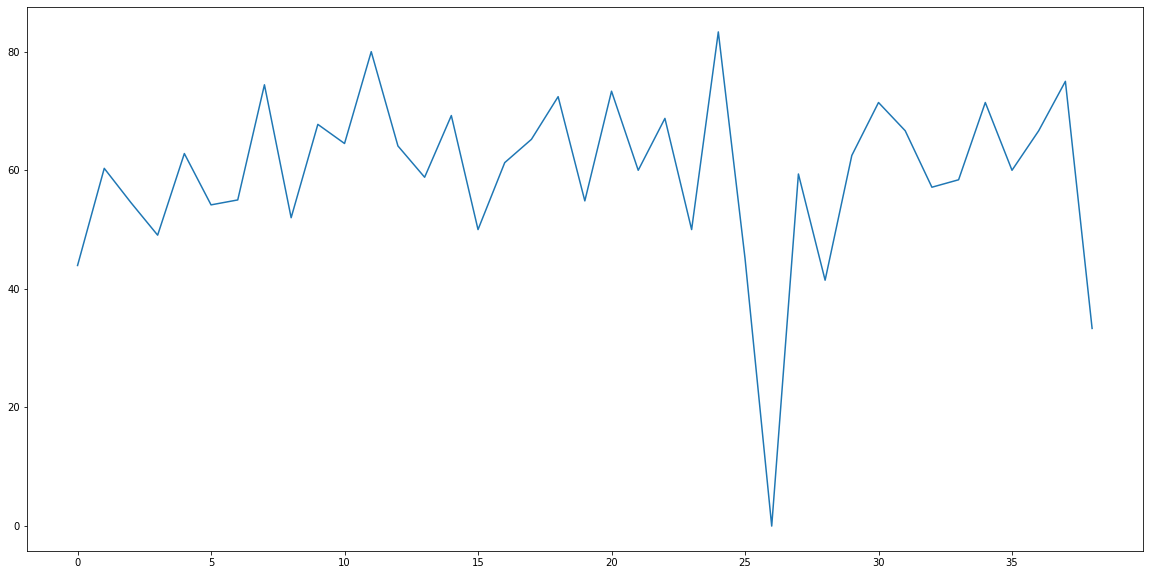

In [7]:
q2_ = """SELECT * , 100.0*promoters/total_users as csat
        FROM (
        SELECT month_,week_, year_ ,
        SUM(score) as promoters,
        COUNT(score) as total_users
        FROM df_n GROUP BY 1,2,3 ) a"""

#print(ps.sqldf(q1, locals()))
df__day = ps.sqldf(q2_, locals())
print(df__day.tail())
plt.plot(df__day.csat)

## All Cumulative

It brings a lot of confidence with the prtedictibility, but it is hard to notice when the metric is on critical ranges. The smoothing effect of the whole aggregation makes hard to notice when something is going wrong

,dates,month_,week_,year_,dayofyear,promoters,total_users,cum_promoters,cum_total_users,csat,cum_csat
206,2019-10-31,10,44,2019,2019304,1,2,998,1712,50.0,58.294393
207,2019-11-01,11,44,2019,2019305,1,1,999,1713,100.0,58.318739
208,2019-11-02,11,44,2019,2019306,1,2,1000,1715,50.0,58.309038
209,2019-11-03,11,44,2019,2019307,1,1,1001,1716,100.0,58.333333
210,2019-11-04,11,45,2019,2019308,1,3,1002,1719,33.0,58.289703


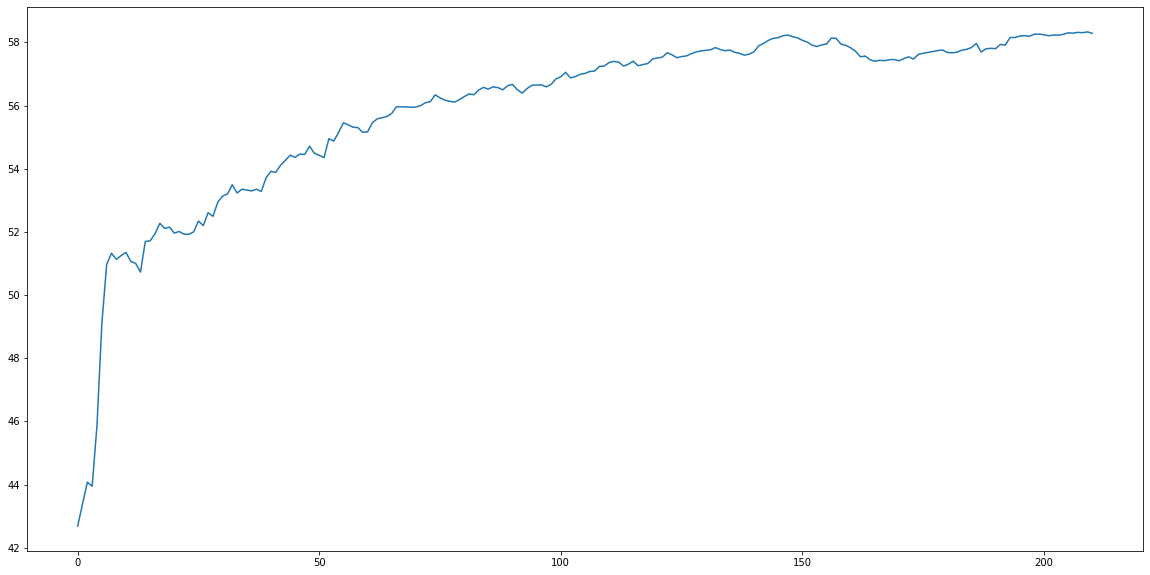

In [35]:

q221 = """SELECT * , 
                ROUND(100.0*promoters/total_users ) as csat,  
                100.0*cum_promoters/cum_total_users as cum_csat
        FROM (
        SELECT a.dates,a.month_,a.week_, a.year_ ,a.dayofyear,  
        a.promoters, a.total_users ,
        sum(b.promoters) as cum_promoters,
        sum(b.total_users) as cum_total_users
        from df_day a inner join df_day b on a.dates >= b.dates 
        group by 1,2,3,4,5,6,7
        order by 1) a"""

#print(ps.sqldf(q1, locals()))
df2_cumday = ps.sqldf(q221, locals())
plt.plot(df2_cumday.cum_csat)
df2_cumday.tail()

## Monthly cummulative

It is the current way to report that metric. As we can see, it's a Lèvy -Îto process with jumps. The volatility is almost bounded but  the beginnig of the month. 

Volatility: 4.415


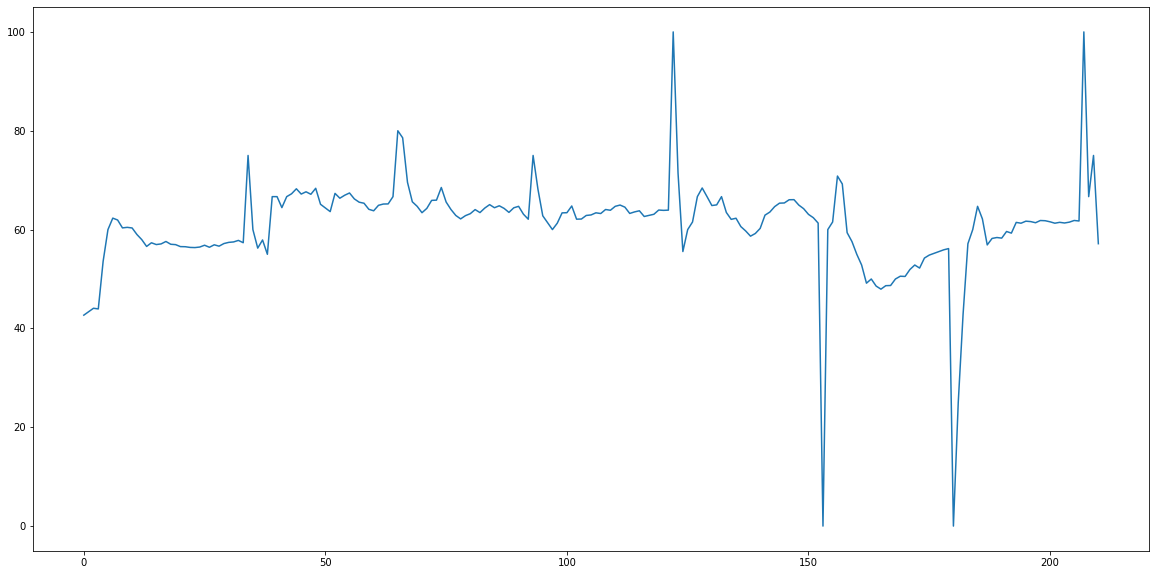

In [9]:

q211 = """SELECT * , 
                ROUND(100.0*promoters/total_users ) as csat,  
                100.0*cum_promoters/cum_total_users as cum_csat
        FROM (
        SELECT a.dates,a.month_,a.week_, a.year_ ,a.dayofyear,  
        a.promoters, a.total_users ,
        sum(b.promoters) as cum_promoters,
        sum(b.total_users) as cum_total_users
        from df_day a inner join df_day b on a.dates >= b.dates and b.month_ = a.month_
        group by 1,2,3,4,5,6,7
        order by 1) a"""

#print(ps.sqldf(q1, locals()))
df_cumday1 = ps.sqldf(q211, locals())
plt.plot(df_cumday1.cum_csat)
vol = df_cumday1.cum_csat.rolling(7).std().mean()
print('Volatility: %.3f' %vol)


ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/xavier.gamito/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


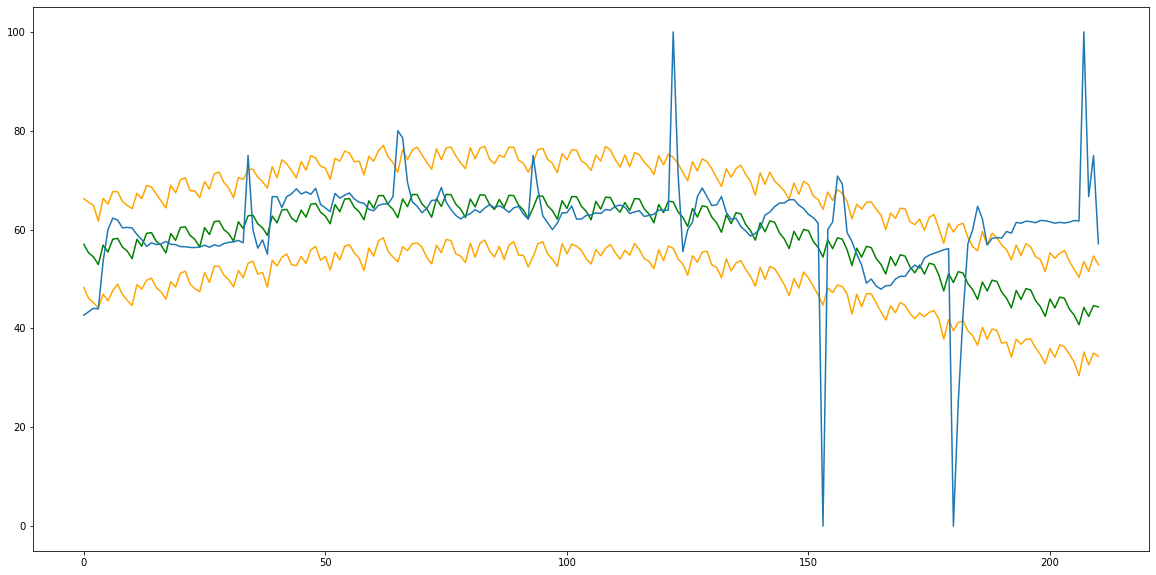

In [10]:

import pandas as pd
import numpy as np
from fbprophet import Prophet
import holidays


_arg3 = 29
period = _arg3+1
df = pd.DataFrame(
    {'ds': df_cumday1.dates,
     'y': df_cumday1.cum_csat
    })
#print(df.ds)
m11 = Prophet()#holidays = holidays)
#m = Prophet(changepoints=['2019-09-19'])
#m.add_country_holidays(country_name='ES')
df = df[:-period]
m11.fit(df);
future11 = m11.make_future_dataframe(periods=period)
forecast11 = m11.predict(future11)
plt.plot(forecast11['yhat'], c = 'green') 
plt.plot(forecast11['yhat_lower'], c = 'orange') 
plt.plot(forecast11['yhat_upper'], c = 'orange') 
plt.plot(df_cumday1.cum_csat)

## PO's anxiety

the result of the PO's electrocardiogram

Volatility: 4.415


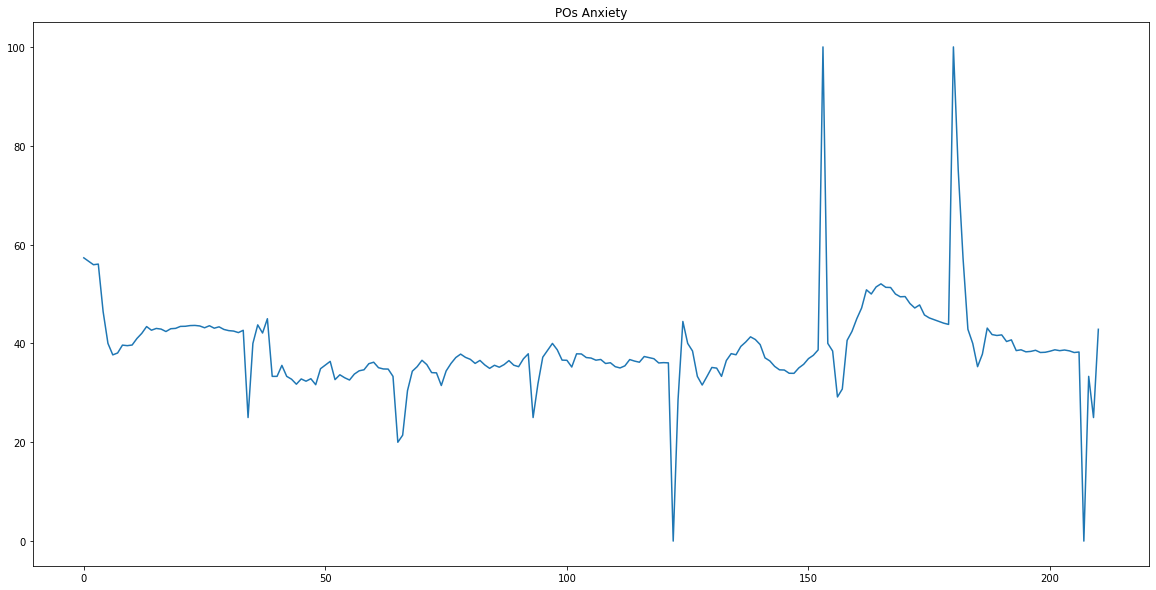

In [11]:
plt.plot(100 - df_cumday1.cum_csat)
plt.title('POs Anxiety')
vol = df_cumday1.cum_csat.rolling(7).std().mean()
print('Volatility: %.3f' %vol)


# New CSAT (30 days rolling window)

Volatility: 1.121


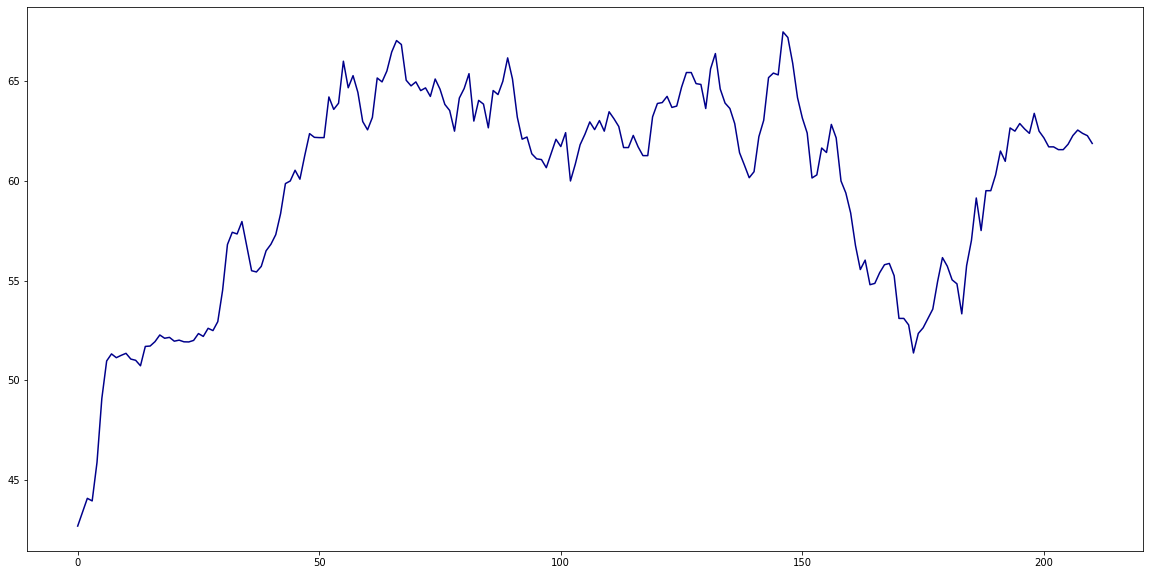

In [12]:

q21 = """SELECT * , 
                ROUND(100.0*promoters/total_users ) as csat,  
                100.0*cum_promoters/cum_total_users as cum_csat
        FROM (
        SELECT a.dates,a.month_,a.week_, a.year_ ,a.dayofyear,  
        a.promoters, a.total_users ,
        sum(b.promoters) as cum_promoters,
        sum(b.total_users) as cum_total_users
        from df_day a inner join df_day b on a.dates >= b.dates and b.dates > datetime(a.dates, '-30 days')
        group by 1,2,3,4,5,6,7
        order by 1) a"""

#print(ps.sqldf(q1, locals()))

df_cumday = ps.sqldf(q21, locals())
plt.plot(df_cumday.cum_csat, c = 'darkblue') 

vol = df_cumday.cum_csat.rolling(7).std().mean()
print('Volatility: %.3f' %vol)

In [13]:
df_comp = df_cumday[['dates', 'cum_csat']]
df_comp['cum_csat_old'] = df_cumday1['cum_csat']
df_comp['diff'] = df_comp.cum_csat - df_comp.cum_csat_old
diff = df_comp['diff']


/Users/xavier.gamito/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/xavier.gamito/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


-1.1564977780809311


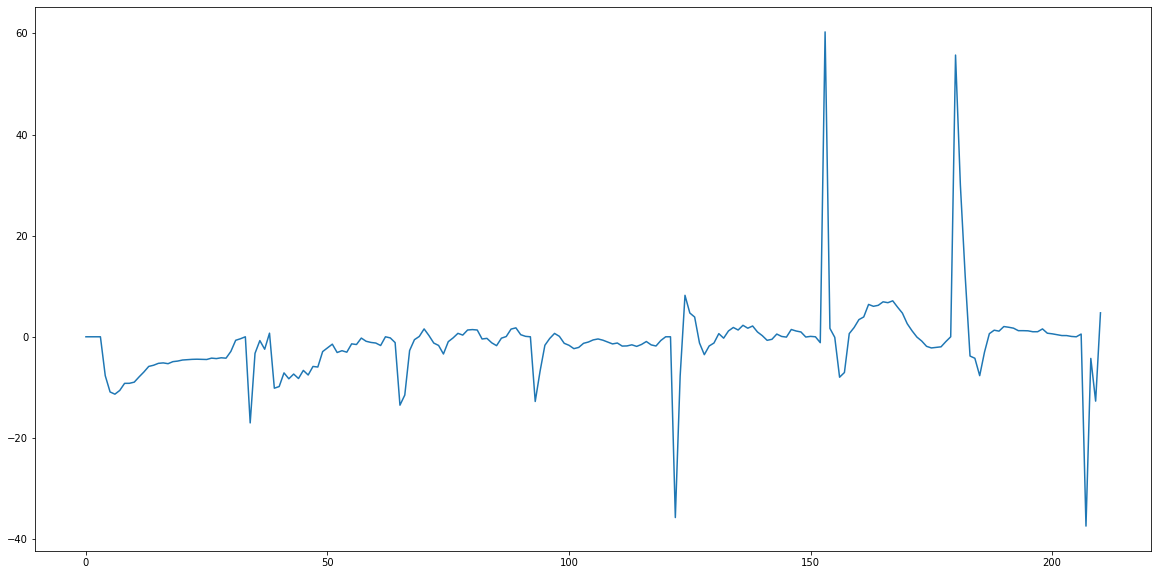

In [14]:

print(diff.mean())

plt.plot(diff)





In [15]:
df_comp.head()





,dates,cum_csat,cum_csat_old,diff
0,2019-03-28,42.682927,42.682927,0.000000
1,2019-03-29,43.386243,43.386243,0.000000
2,2019-03-30,44.075829,44.075829,0.000000
3,2019-03-31,43.946188,43.946188,0.000000
4,2019-04-01,45.878136,53.571429,-7.693292


## Volatility Comparison

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


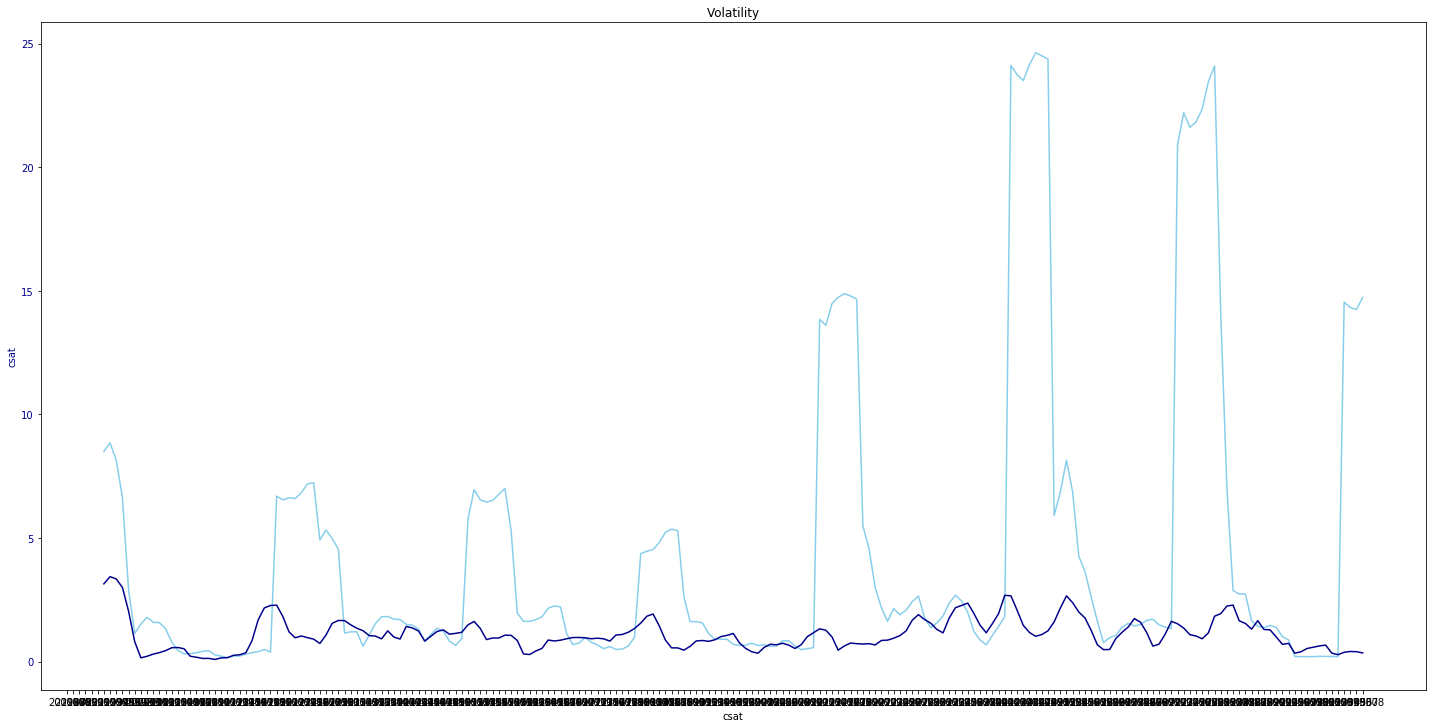

In [16]:
import numpy as np
import matplotlib.pyplot as plt

t = df_cumday1.dayofyear
data1 = df_cumday1.cum_csat.rolling(7).std()
data1_ = df_cumday.cum_csat.rolling(7).std()


fig, ax1 = plt.subplots()

color = 'darkblue'
ax1.set_xlabel('csat')
ax1.set_ylabel('csat', color=color)
ax1.plot(t, data1, color='skyblue', alpha=1)
ax1.plot(t, data1_, color='darkblue', alpha=1)
ax1.tick_params(axis='y', labelcolor=color)




fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Volatility')
plt.show()

## CSAT Comparison

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


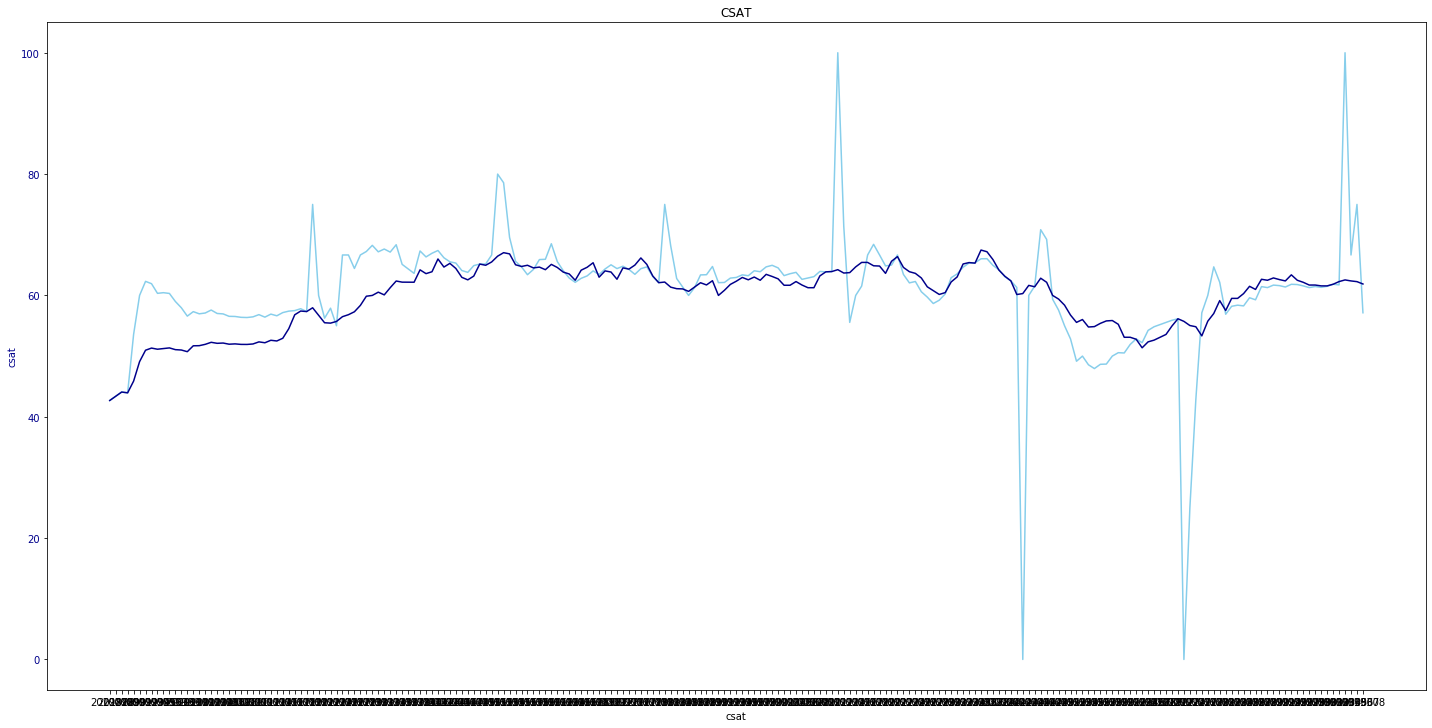

In [17]:
import numpy as np
import matplotlib.pyplot as plt

t = df_cumday1.dayofyear
data1 = df_cumday1.cum_csat
data1_ = df_cumday.cum_csat


fig, ax1 = plt.subplots()

color = 'darkblue'
ax1.set_xlabel('csat')
ax1.set_ylabel('csat', color=color)
ax1.plot(t, data1, color='skyblue', alpha=1)
ax1.plot(t, data1_, color='darkblue', alpha=1)
ax1.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('CSAT')
plt.show()

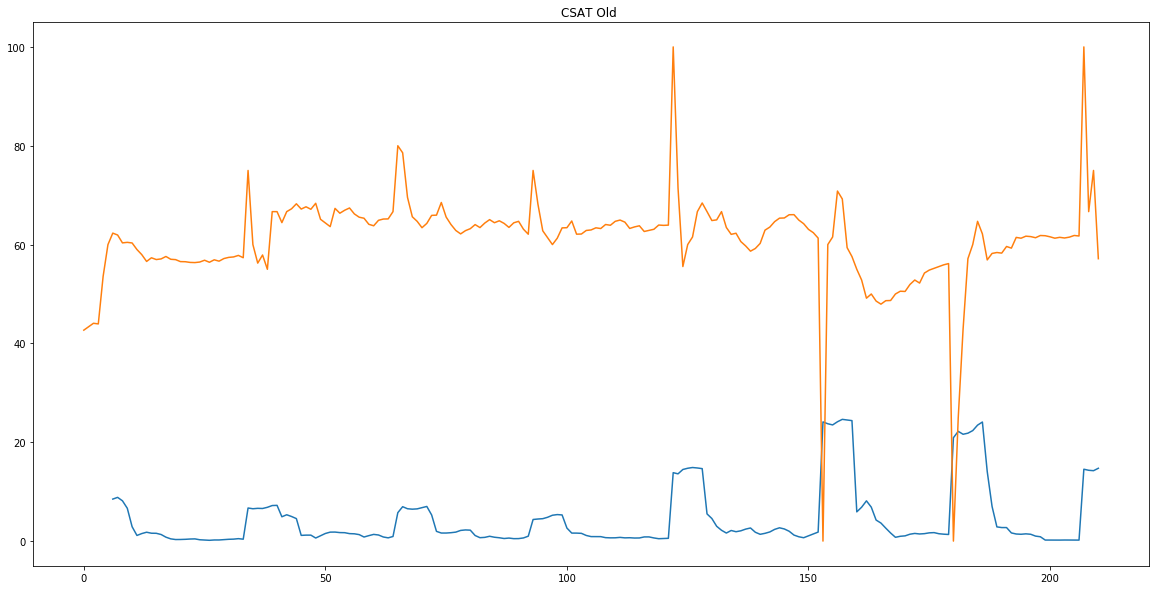

In [18]:
plt.title('CSAT Old ')
plt.plot(df_cumday1.cum_csat.rolling(7).std())
plt.plot(df_cumday1.cum_csat)




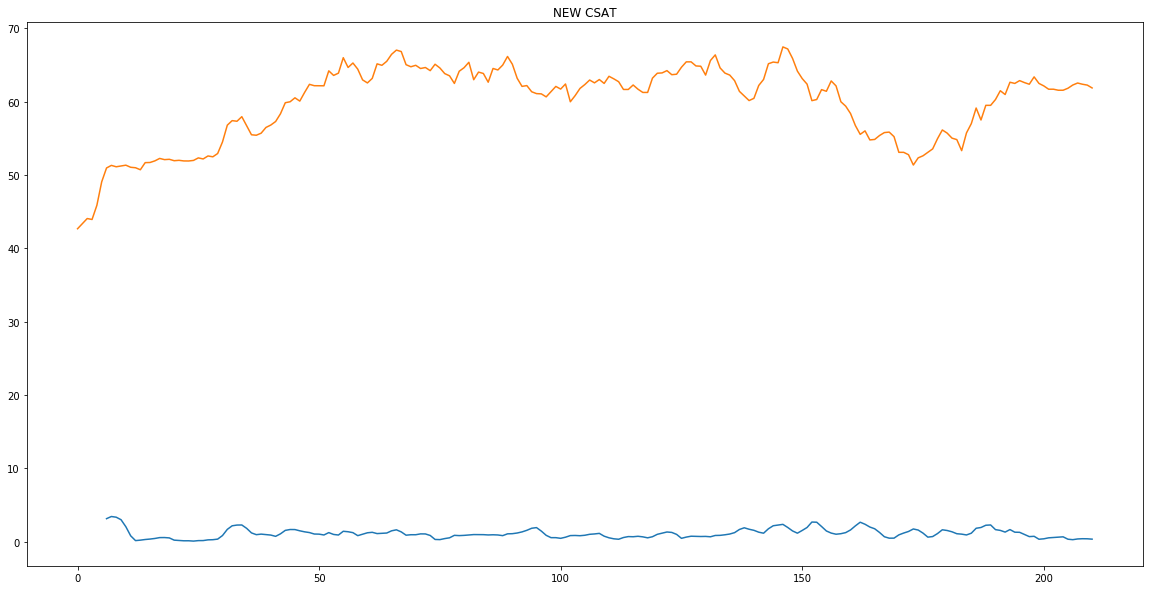

In [19]:
plt.title('NEW CSAT')
plt.plot(df_cumday.cum_csat.rolling(7).std())
plt.plot(df_cumday.cum_csat)



## Deep Dive on users

# Saturation coefficient
## Usefull metric oriented to PRO teams (Client)

We noticed in the PRO teams, we have few users to impact with CSAT. 
### Hypotesis: If they are excluded once they answer, we tend to consume the promoters. 

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


aprox: 6.500 customers


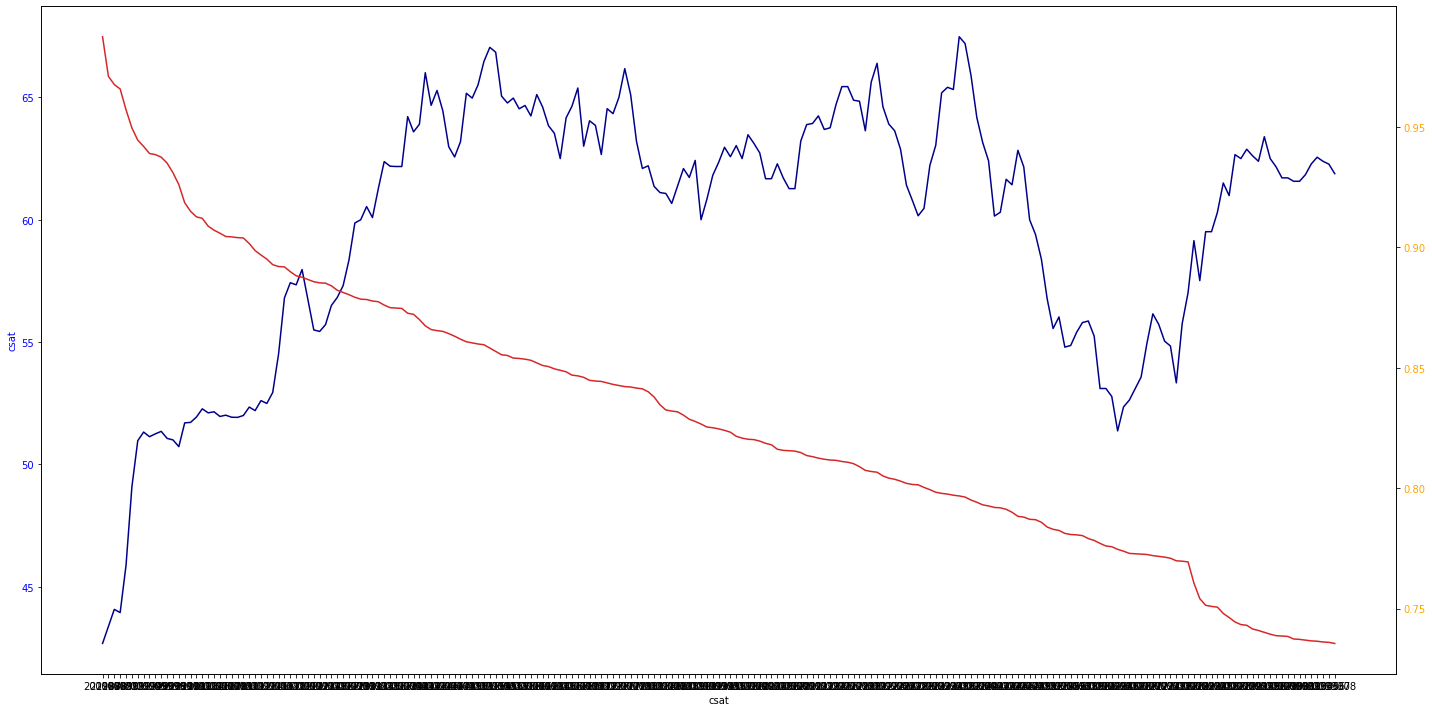

In [20]:
print('aprox: 6.500 customers')
cust = 6500.0

# Create some mock data
t = df_cumday.dayofyear
data1 = df_cumday.cum_csat

fig, ax1 = plt.subplots()

color = 'blue'
ax1.set_xlabel('csat')
ax1.set_ylabel('csat', color=color)
ax1.plot(t, data1, color='darkblue', alpha=1)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.plot(t, 1-(df2_cumday.cum_total_users)/cust, color=color)


ax2.tick_params(axis='y', labelcolor='orange')


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [21]:
print(df_cumday[160:].iloc[df_cumday.cum_csat.idxmin(axis=0, skipna=True)])


dates              2019-09-09
month_                      9
week_                      37
year_                    2019
dayofyear             2019252
promoters                   3
total_users                 7
cum_promoters              80
cum_total_users           137
csat                       43
cum_csat              58.3942
Name: 160, dtype: object


In [64]:
df_cumday[(df_cumday.week_ >= 43) & (df_cumday.week_  < 46)]

,dates,month_,week_,year_,dayofyear,promoters,total_users,cum_promoters,cum_total_users,csat,cum_csat
196,2019-10-21,10,43,2019,2019294,6,10,139,222,60.0,62.612613
197,2019-10-22,10,43,2019,2019295,2,4,141,226,50.0,62.389381
198,2019-10-23,10,43,2019,2019296,4,5,142,224,80.0,63.392857
199,2019-10-24,10,43,2019,2019297,3,5,140,224,60.0,62.500000
200,2019-10-25,10,43,2019,2019298,2,4,138,222,50.0,62.162162
201,2019-10-26,10,43,2019,2019299,0,1,137,222,0.0,61.711712
202,2019-10-27,10,43,2019,2019300,1,1,137,222,100.0,61.711712
203,2019-10-28,10,44,2019,2019301,4,7,141,229,57.0,61.572052
204,2019-10-29,10,44,2019,2019302,1,1,141,229,100.0,61.572052
205,2019-10-30,10,44,2019,2019303,2,2,141,228,100.0,61.842105


# Predictibility

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/xavier.gamito/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


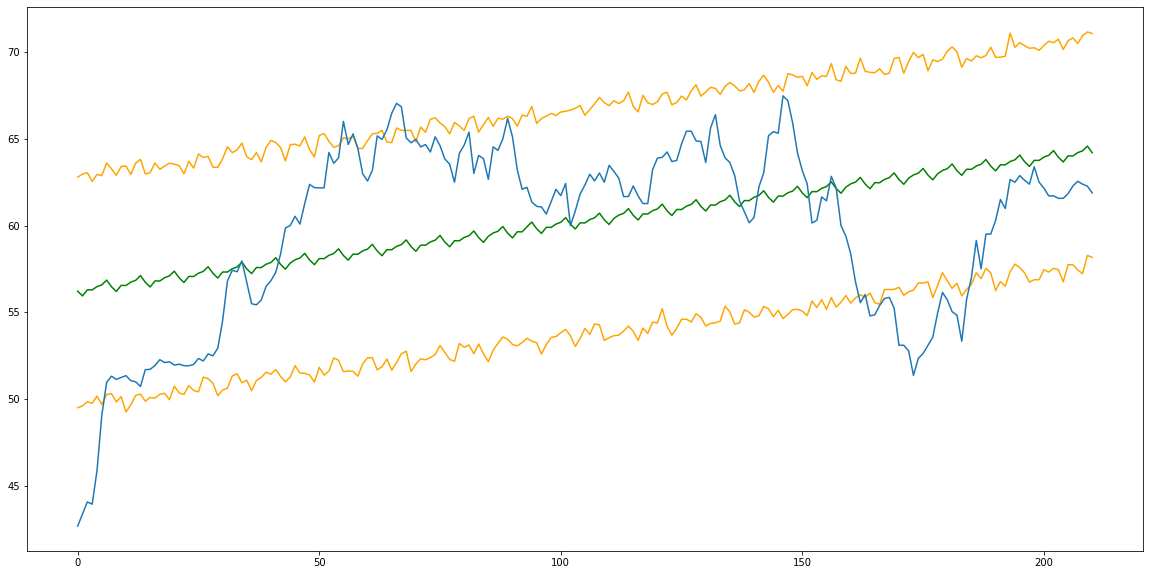

In [22]:

import pandas as pd
import numpy as np
from fbprophet import Prophet
import holidays


_arg3 = 29
period = _arg3+1
df = pd.DataFrame(
    {'ds': df_cumday.dates,
     'y': df_cumday.cum_csat
    })
#print(df.ds)
m = Prophet()#holidays = holidays)
m = Prophet(changepoints=['2019-09-19'])
#m.add_country_holidays(country_name='ES')
df = df[:-period]
m.fit(df);
future = m.make_future_dataframe(periods=period)
forecast = m.predict(future)
plt.plot(forecast['yhat'], c = 'green') 
plt.plot(forecast['yhat_lower'], c = 'orange') 
plt.plot(forecast['yhat_upper'], c = 'orange') 
plt.plot(df_cumday.cum_csat)


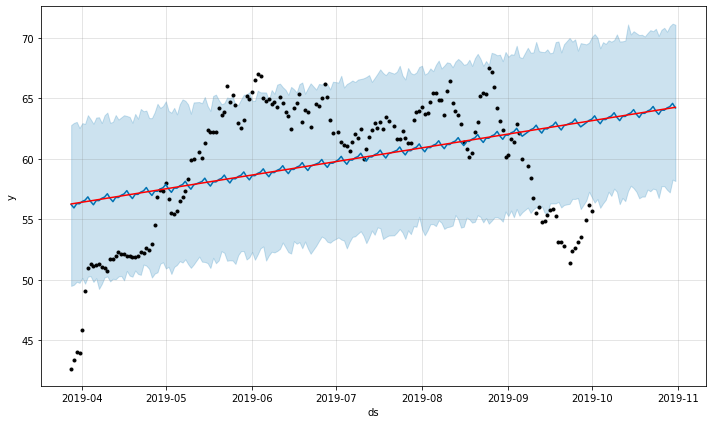

In [23]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


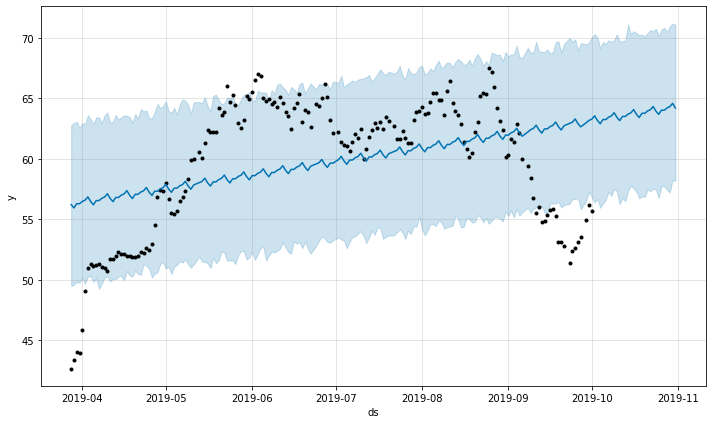

In [24]:
fig1 = m.plot(forecast)


# Predictions using FbProphet. 
## zooming on trends changes, forecasting and thresholds

Here we are about to finish our analysis. Since we can control volatility, we can apply many forecasting methods in order to understand the upcoming behaviour from our NPS metric

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/xavier.gamito/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


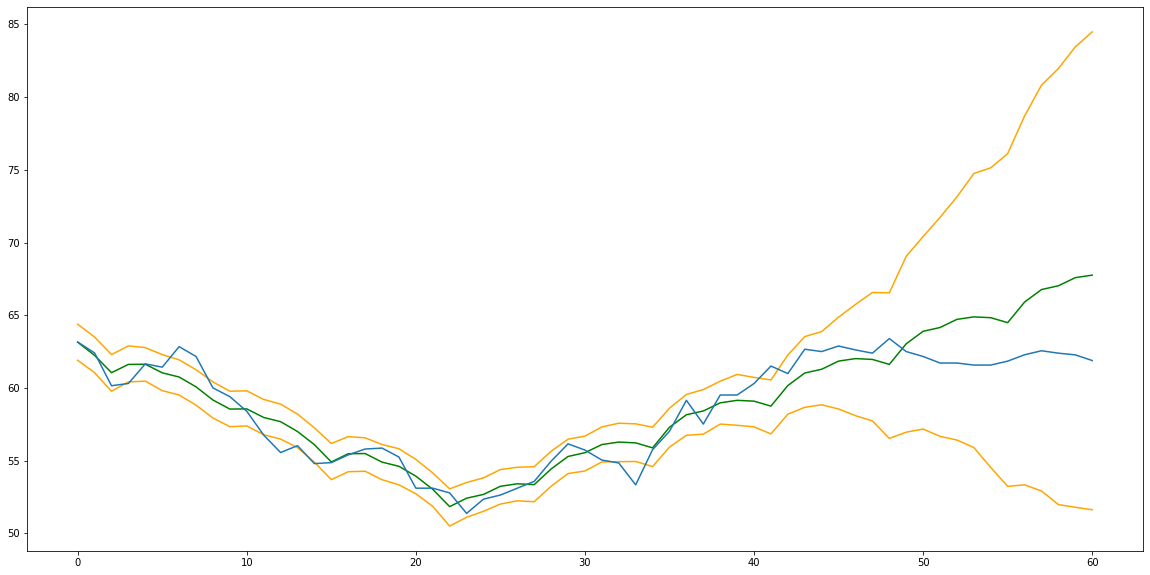

In [53]:

import pandas as pd
import numpy as np
from fbprophet import Prophet
import holidays

df_cumday_prophet = df_cumday[150:]
df_cumday_prophet = df_cumday_prophet.reset_index()

_arg3 = 29
period = _arg3+1
df = pd.DataFrame(
    {'ds': df_cumday_prophet.dates,
     'y': df_cumday_prophet.cum_csat
    })
#print(df.ds)
m1 = Prophet()#holidays = holidays)
m1 = Prophet(changepoints=['2019-09-23'])
#m.add_country_holidays(country_name='ES')
df = df[:-period]
m1.fit(df);
future1 = m1.make_future_dataframe(periods=period)
forecast1 = m1.predict(future1)
plt.plot(forecast1['yhat'], c = 'green') 
plt.plot(forecast1['yhat_lower'], c = 'orange') 
plt.plot(forecast1['yhat_upper'], c = 'orange') 
plt.plot(df_cumday_prophet.cum_csat)


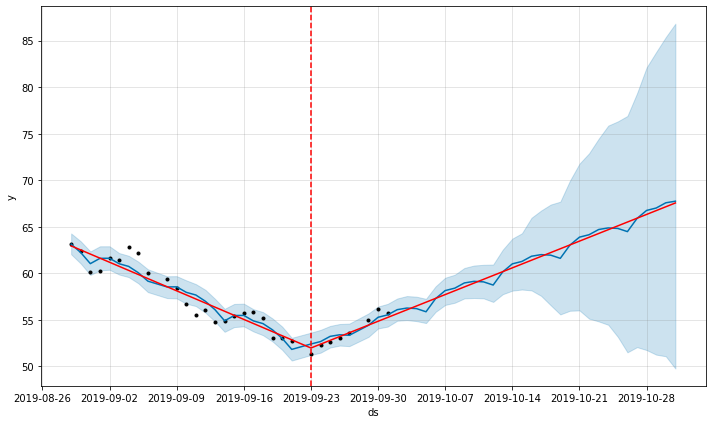

In [51]:
from fbprophet.plot import add_changepoints_to_plot
fig = m1.plot(forecast1)
a = add_changepoints_to_plot(fig.gca(), m1, forecast1)


In [27]:
future.dtypes


ds    datetime64[ns]
dtype: object

# Creating Future Dataframe
## We need a single type of data to feed the model

we create the DataFrame with pandaSQL, but each one can choose its own way.  Only need to b e same type

In [28]:

qds ="""
        SELECT date('2019-11-05') as dates UNION
        SELECT date('2019-11-06') as dates UNION
        SELECT date('2019-11-07') as dates UNION
        SELECT date('2019-11-08') as dates UNION
        SELECT date('2019-11-09') as dates UNION
        SELECT date('2019-11-10') as dates UNION
        SELECT date('2019-11-11') as dates UNION
        SELECT date('2019-11-12') as dates UNION
        SELECT date('2019-11-13') as dates UNION
        SELECT date('2019-11-14') as dates UNION
        SELECT date('2019-11-15') as dates UNION
        SELECT date('2019-11-16') as dates UNION
        SELECT date('2019-11-17') as dates UNION
        SELECT date('2019-11-18') as dates UNION
        SELECT date('2019-11-19') as dates UNION
        SELECT date('2019-11-20') as dates UNION
        SELECT date('2019-11-21') as dates UNION
        SELECT date('2019-11-22') as dates UNION
        SELECT date('2019-11-23') as dates UNION
        SELECT date('2019-11-24') as dates UNION
        SELECT date('2019-11-25') as dates UNION
        SELECT date('2019-11-26') as dates UNION
        SELECT date('2019-11-27') as dates UNION
        SELECT date('2019-11-28') as dates UNION
        SELECT date('2019-11-29') as dates UNION
        SELECT date('2019-11-30') as dates UNION
        SELECT date('2019-12-01') as dates UNION
        SELECT date('2019-12-02') as dates UNION
        SELECT date('2019-12-03') as dates UNION
        SELECT date('2019-12-04') as dates UNION
        SELECT date('2019-12-05') as dates 
        """

#print(ps.sqldf(q1, locals()))
datesdf = ps.sqldf(qds, locals())

datesdf['dayofyear'] = pd.to_datetime(datesdf['dates']).dt.dayofyear.astype(int)
datesdf['week_'] = pd.to_datetime(datesdf['dates']).dt.week.astype(int)
datesdf['year_'] = pd.to_datetime(datesdf['dates']).dt.year.astype(int)
datesdf['month_'] = pd.to_datetime(datesdf['dates']).dt.month.astype(int)

qds ="""
        SELECT dates as ds, month_,week_,year_,year_||dayofyear as dayofyear
        from datesdf
        
        """
#print(ps.sqldf(q1, locals()))
datesdf = ps.sqldf(qds, locals())

X_predict = datesdf[['dayofyear']].copy()



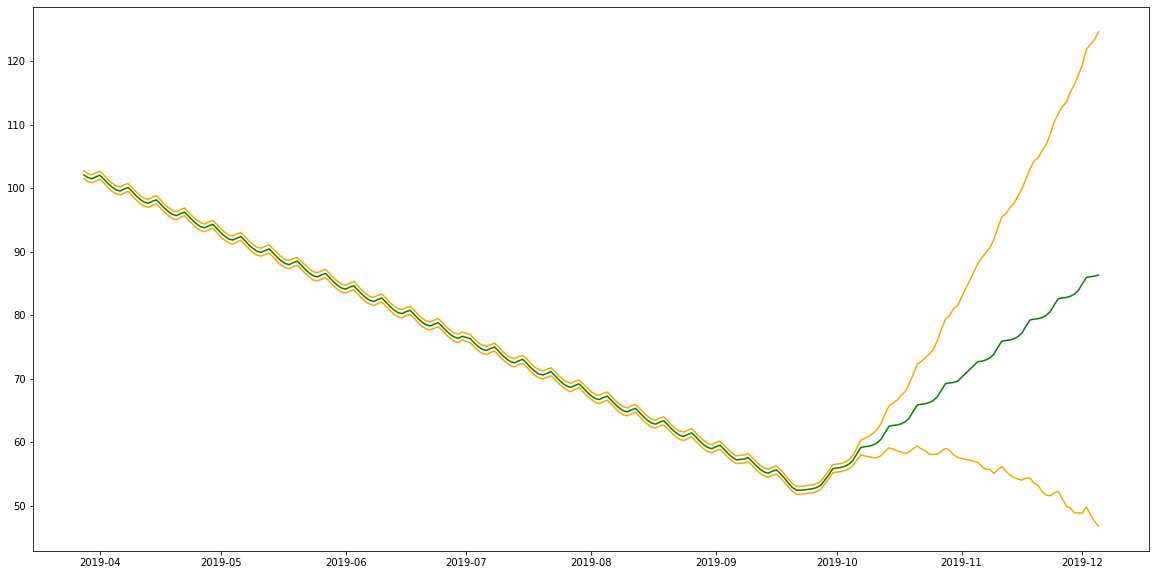

In [29]:

qdvs ="""select date(ds) as ds from future union 
         select date(ds) as ds from datesdf"""

#print(ps.sqldf(q1, locals()))
lalallala = ps.sqldf(qdvs, locals())



forecast1 = m1.predict(lalallala)
plt.plot(forecast1.ds, forecast1['yhat'], c = 'green') 
plt.plot(forecast1.ds, forecast1['yhat_lower'], c = 'orange') 
plt.plot(forecast1.ds, forecast1['yhat_upper'], c = 'orange') 


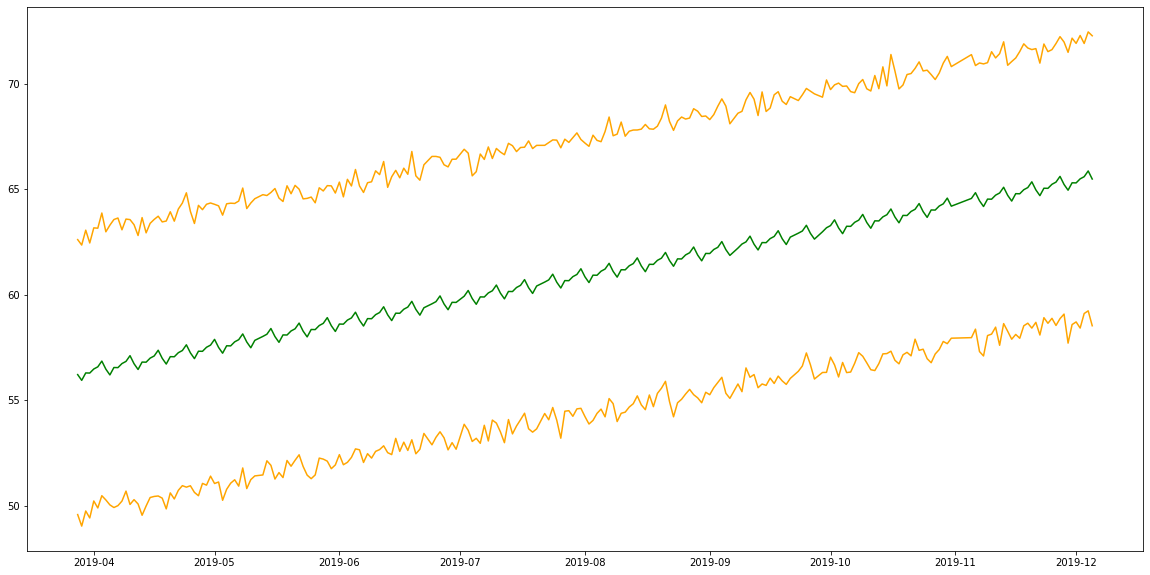

In [30]:
forecast = m.predict(lalallala)
plt.plot(forecast.ds, forecast['yhat'], c = 'green') 
plt.plot(forecast.ds, forecast['yhat_lower'], c = 'orange') 
plt.plot(forecast.ds, forecast['yhat_upper'], c = 'orange') 


## Save the file with predictions and thresholds

In [31]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('CSAT_thresholds_Nov.csv')
#df_cumday_prophet.to_csv('CSAT_real_NOV.csv')


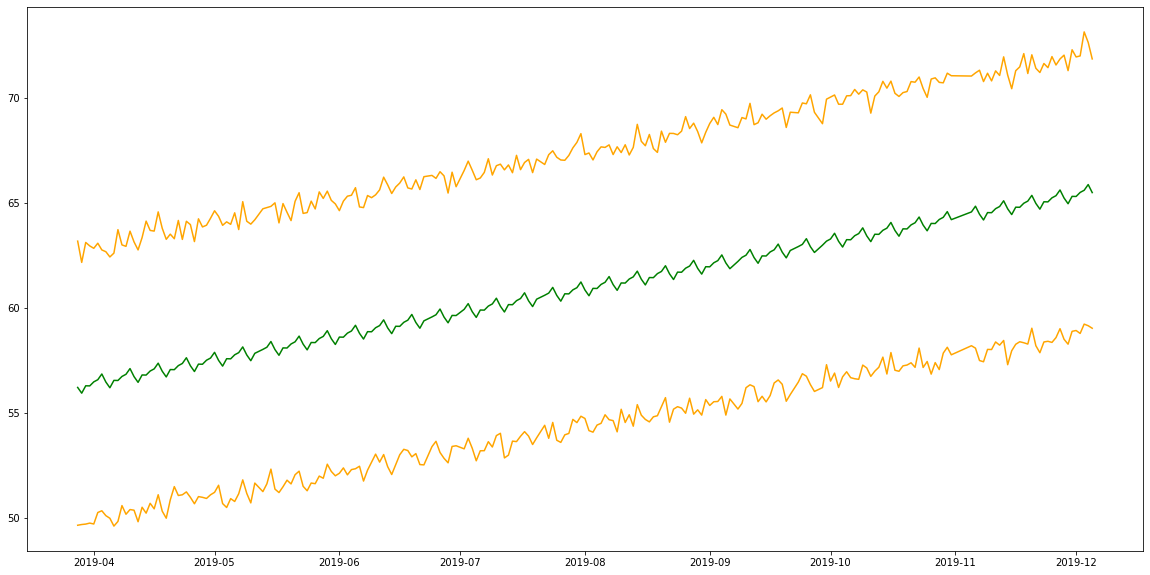

In [32]:

forecast = m.predict(lalallala)
plt.plot(forecast.ds, forecast['yhat'], c = 'green') 
plt.plot(forecast.ds, forecast['yhat_lower'], c = 'orange') 
plt.plot(forecast.ds, forecast['yhat_upper'], c = 'orange') 




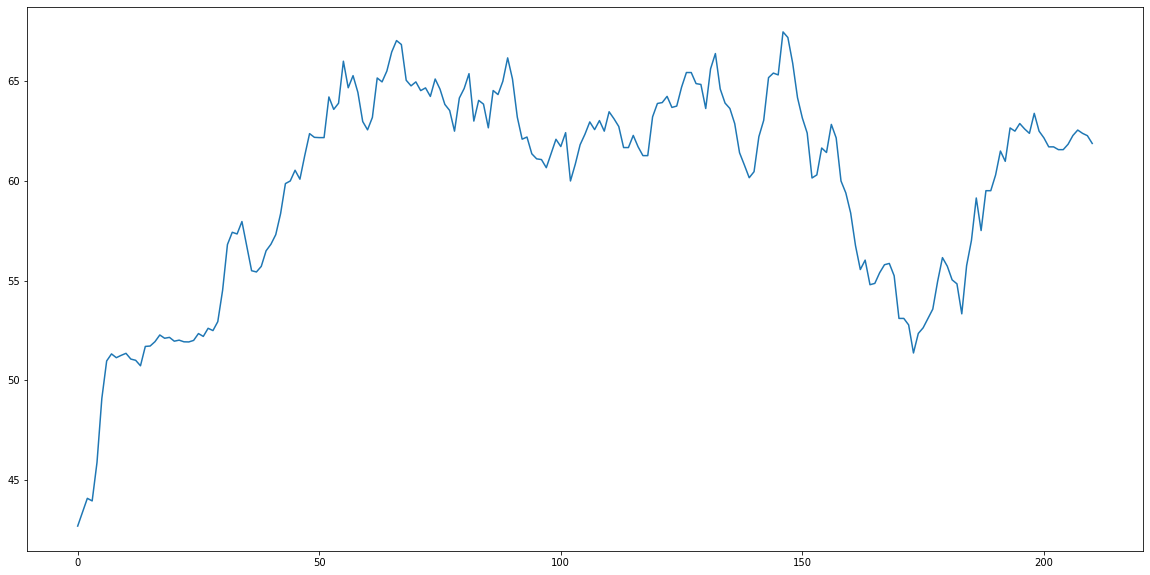

In [33]:
plt.plot(df_cumday.cum_csat)
